# Tricuspid Doppler Trace Segmentation

**Note**: The data cannot be uploaded because it is private health data.

The heart consists of the following chambers:
- **Aortic valve** - keeps blood flowing in the correct direction through the heart. It is located at the top of the the left lower chamber.
- **Mitral valve** - seperates the left upper and left lower chambers of the heart. It stops the blood from flowing in the wrong way.
- **Triscupid valve** - allows the blood flowing into the heart from the body to flow to the right ventricle. The blood is pumped to the lungs for oxygen.
- **Pulmonary valve** - is a one-way door from the heart's right ventricle to the lungs.

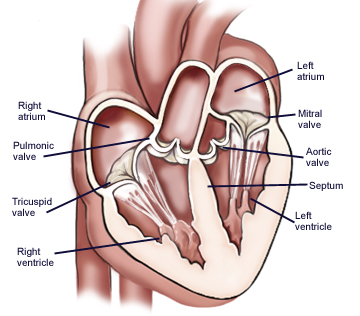

**Doppler echocardiography** is used to measure and assess the flow of blood through the heart's chambers and valves. The amount of blood pumped out with each beat is an indicator of the heart's functioning. It can also detect abnormal blood flow within the heart, which can indicate a problem with one or more of the heart's four valves, or with the heart's walls.

## Initial set up

In [ ]:
# Used to access the dataset on personal Google Drive
from google.colab import drive

# Used for data manipulation and visualization
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os 
from PIL import Image

# Used to preprocess data
import torch
import torchvision
from torchvision import transforms as T, datasets, models
import random

# Used to develop CNNs
from torch import nn
from torch.nn import functional as F

# Used to calculate Hausdorff distance
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
from scipy.ndimage import _ni_support

# Used for heart beat calculations
from statistics import mode
from scipy.signal import argrelextrema, find_peaks

# Save history of model's training
import pickle

# Remove notebook warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Install smp and import it - used to train the U-net model and validate it
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

# Install monai and import it - used to convert an image from 3 channels to 1 channel
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
from monai.transforms import Lambdad

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper Functions

In [ ]:
# Load images into numpy arrays
def load(path, folder, imgSize):

  FOLDERS = [folder]
  # Classification works good at image size 224 x 224
  SIZE = imgSize

  data = []

  # Go through every folder in dataset
  for folder in FOLDERS:
    fullPath = os.path.join(path, folder)

    # Go through every image in the folder
    for img in os.listdir(fullPath):
      # Get image's full path
      imgPath = os.path.join(fullPath, img)

      try:
        # Get data from image
        imgData = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        # Resize image - not all images have the same size
        resized = cv2.resize(imgData, (SIZE, SIZE))
        # Add resized image and label of image - tuple
        data.append(resized)
      except Exception as e:
        print(e)

  return np.array(data)

In [ ]:
# Show a single image
def showImage(data, label):
  # Resize figure
  plt.rcParams["figure.figsize"] = (5,5)
  plt.title(label)
  # Display image
  plt.imshow(data)
  plt.axis('off')
  plt.plot()

In [ ]:
# Show a list of images
def showTricuspid(img_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(img_list)):
    plt.subplot(1, len(img_list), i+1)
    plt.title(title[i])
    plt.imshow(img_list[i])
    plt.axis('off')
    
  plt.show()

In [ ]:
# Save model at location: given path followed by model/u-next.pth (generated within saveModel)
def saveModel(model, path):
  # Append model folder to path
  modelPath = os.path.join(PATH, "model")

  # Create path if it does not exist
  if not os.path.exists(modelPath):
    os.makedirs(modelPath)

  # Create model's name
  modelPath = os.path.join(modelPath, "u-net.pth")
  # Save model to drive
  torch.save(model, modelPath)

  print(f"Model successfully saved - {modelPath}")

In [ ]:
# Load model at location: given path followed by model/u-next.pth (generated within saveModel)
def loadModel(path):
  # Append model folder to path
  modelPath = os.path.join(PATH, "model")
  # Create model's name
  modelPath = os.path.join(modelPath, "u-net.pth")
  
  # If file does not exist - raise error
  assert os.path.isfile(modelPath), f"File {modelPath} does not exist.\nMake sure the model has been trained before you can load it."

  model = torch.load(modelPath)
  
  return model

In [ ]:
# Convert train/test image from 4d to 2d
def reshapeBaseImage(image):
  # Convert the image to a np array
  image = image.cpu().detach().numpy()
  # Reshape the image 4d -> 3d
  image = np.reshape(image, (image.shape[1], image.shape[2], image.shape[3]))

  # Reshape the image 3d (3 channels) -> to 2d (1 channel)
  lambd = Lambdad(keys='image', func=lambda x: x[0:1]*0.2125 + x[1:2]*0.7154 + x[2:3]*0.0721)
  data = {'image': image}
  transformed = lambd(data)["image"]
  transformed = np.reshape(transformed, (transformed.shape[1], transformed.shape[2]))

  return transformed

In [ ]:
# Save history at location: given path followed by model/history.pth (generated within saveHistory)
def saveHistory(history, path):
  # Append history folder to path
  historyPath = os.path.join(PATH, "model")

  # Create path if it does not exist
  if not os.path.exists(historyPath):
    os.makedirs(historyPath)

  # Create model's name
  modelPath = os.path.join(historyPath, "history.pickle")

  # Save model to drive
  with open(modelPath, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

  print(f"History successfully saved - {modelPath}")

In [ ]:
# Load model at location: given path followed by model/u-next.pth (generated within saveModel)
def loadHistory(path):
  # Append model folder to path
  historyPath = os.path.join(PATH, "model")
  # Create model's name
  historyPath = os.path.join(historyPath, "history.pickle")
  
  # If file does not exist - raise error
  assert os.path.isfile(historyPath), f"File {historyPath} does not exist."

  with open(historyPath, 'rb') as handle:
    history = pickle.load(handle)
  
  return history

In [ ]:
# Display the loss and the iou score
def showHistory(history):
  plt.figure(figsize=(15, 7))
  fig, ax = plt.subplots(1, 2, figsize=(25, 7))

  ax[0].title.set_text("Train and Test Dice Loss")
  ax[0].plot(history["epochs"], history["train_logs"]["dice_loss"])
  ax[0].plot(history["epochs"], history["test_logs"]["dice_loss"])
  ax[0].set_ylabel("Dice Loss")
  ax[0].set_xlabel("Epoch")
  ax[0].legend(["Train", "Test"])


  ax[1].title.set_text("Train and Test IoU Score")
  ax[1].plot(history["epochs"], history["train_logs"]["iou_score"])
  ax[1].plot(history["epochs"], history["test_logs"]["iou_score"])
  ax[1].legend(["Train", "Test"])
  ax[1].set_ylabel("IoU Score")
  ax[1].set_xlabel("Epoch")
  ax[1].legend(["Train", "Test"])

  plt.show()

In [ ]:
# Show the beats in different colours and their area
def showBeatResults(path):
  # Open the image path in grayscale
  mask = cv2.imread(path, 0)

  # Get the areas
  areas, img = beatArea(mask)
  
  for i in range(len(areas)):
    print(f"The area of beat {i + 1} is:\t{areas[i]}\n")

  # Visualization
  showImage(img, f"Found beats: {len(areas)}")

In [ ]:
# Display random image and its stats
def showRandombeat(path):
  path = os.path.join(path, "annotations_binary/testing")
  imgPaths = []

  for img in os.listdir(path):
    # Get the full path of the image and append it in list
    imgPaths.append(os.path.join(path, img))
  
  randomPath = random.choice(imgPaths)

  showBeatResults(randomPath)

## Dataset Paramters

We will declare all of the parameters that will be used to load the dataset:

**NOTE**: We use `load` to load the images into numpy for the following reasons:
1. We can visualize an image and its mask
2. We can divide the training set into batches based on the size of the training dataset (`shape[0]`) if needed.

In [ ]:
# Load images into numpy arrays
def load(path, folder, imgSize):

  FOLDERS = [folder]
  # Classification works good at image size 224 x 224
  SIZE = imgSize

  data = []

  # Go through every folder in dataset
  for folder in FOLDERS:
    fullPath = os.path.join(path, folder)
    all_files = sorted(os.listdir(fullPath))
    # Go through every image in the folder
    for img in all_files:
      # Get image's full path
      imgPath = os.path.join(fullPath, img)

      try:
        # Get data from image
        imgData = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        # Resize image - not all images have the same size
        resized = cv2.resize(imgData, (SIZE, SIZE))
        # Add resized image and label of image - tuple
        data.append(resized)
      except Exception as e:
        print(e)

  return np.array(data)

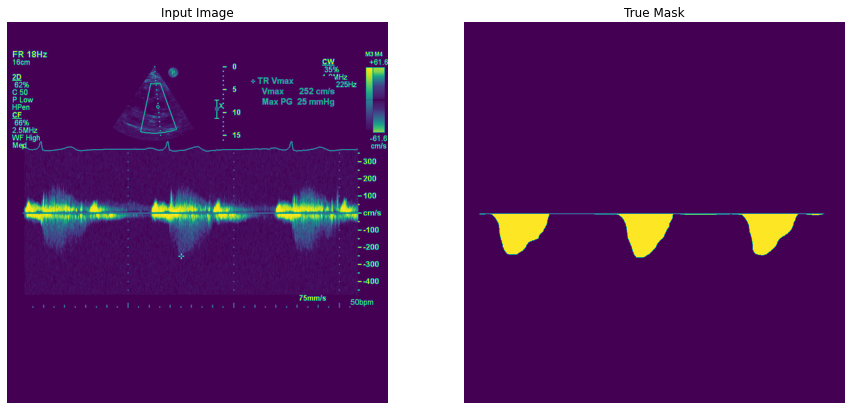

In [ ]:
# Paths for tricuspid images and their annotation - train and test data
PATH = "/content/drive/My Drive/Colab Notebooks/Practice/Datasets/Tricuspid/"
# Images path
IMAGES = os.path.join(PATH, "images")
# Images' annotation path
ANNOTATIONS = os.path.join(PATH, "annotations_binary")

# Size per image (SIZE x SIZE)
SIZE = 1024

# Load data with numpy to quickly inspect the images

# Load train data
train = load(IMAGES, "training", SIZE)
train_annotations = load(ANNOTATIONS, "training", SIZE)
# Load test data
test = load(IMAGES, "testing", SIZE)

# Display training data and its annotation
showTricuspid([train[0], train_annotations[0]])

BATCH = 2

In [ ]:
print(f"There are {train.shape[0]} training examples.\n")
print(f"There are {test.shape[0]} testing examples.")

There are 104 training examples.

There are 19 testing examples.


## Data Preparation

In order for us to train a U-Net model, first we need to load the data correctly. In this scenario we need a pair of the image and its mask which can be achieved with `torch.utils.data.Dataset`. We overwrite the `__init__`, `__len__` and `__getitem__` functions so the dataset fits our scenario. Then we preprocess the data (`preprocess`) so it is ready to be given to the model.

In [ ]:
# Custom torch.utils.data.Dataset class to load the Tricuspid Doppler data
class TricuspidDataset(torch.utils.data.Dataset):
  """
    - image_dir - image directory for training and testing
    - segmentation_dir - image directory for segmentations of the images for training and testing
    - mode - select "training" or "testing" mode for image path
    - transform_img - what transformations to pass to the images
    - transform_seg - what transformations to pass to the segmentations
  """
  def __init__(self, image_dir, segmentation_dir, mode):
    super(TricuspidDataset, self).__init__()
    # Determine if data augmentation should be performed on image 
    self.mode = mode
    # Concatanate the image/segmentation directory with the training/testing directory
    self.image_dir = os.path.join(image_dir, self.mode)
    self.segmentation_dir = os.path.join(segmentation_dir, self.mode)

    filenames = os.listdir(self.image_dir)
    filenames = list(map(lambda x: x.split('.')[0], filenames))

    # Get list of images
    self.image_paths = list(map(lambda x: os.path.join(self.image_dir, x+'.jpg'), filenames))
    # Get list of segmentation for the images
    self.segmentation_paths = list(map(lambda x: os.path.join(self.segmentation_dir, x+'.png'), filenames))


    # Test if the latter lists have the same size - if they don't the assert error will be triggered
    assert len(self.image_paths) == len(self.segmentation_paths), f"Make sure image_dir and segmentation_dir need to have the same number of files.\n\nimage_dir files: {len(self.image_paths)}\nsegmentation_dir files: {len(self.segmentation_paths)}"
  

  # Display the length of the image list (NOTE: image and segmentation lists should have the same length)
  def __len__(self):
    return len(self.image_paths)

  # Convert the index image and segmentation
  def __getitem__(self, index):
    # Make image 1 layer rather than 3
    image = Image.open(self.image_paths[index]).convert("RGB")
    # Scale down image
    image = np.asarray(image) / 255

    segmentation = Image.open(self.segmentation_paths[index]).convert("L")
    
    # Store all of the transformations
    # 1) Convert to Tensor
    transformations = [T.ToTensor()]

    # 2) Resize image to given size
    transformations.append(T.Resize([SIZE, SIZE]))

    # Compose the transformations together
    transform = T.Compose(transformations)

    image = transform(image)
    segmentation = transform(segmentation)
    
    image = torch.tensor(image, dtype = torch.float)
    segmentation = torch.tensor(segmentation, dtype = torch.float)

    return image, segmentation

In [ ]:
"""
  Preprocesses the training / testing images and annotations
  - images_path - path of the train/test images that the model will train with / predict
  - annotations_path - path of the train/test annotations
  - mode - either training or testing. This is used to load either training or testing data
  - batch - the batch size
""" 
def preprocess(images_path, annotations_path, mode, batch):

  assert mode == "training" or mode == "testing", f"Parameter mode should either be \"training\" or \"testing\".Given value: {mode}"

  # Prepare Tricuspid Doppler dataset
  data = TricuspidDataset(images_path, annotations_path, mode)
  # Load the dataset, split it into batches and shuffle it
  data = torch.utils.data.DataLoader(data, batch_size = batch, shuffle = True)

  return data

In [ ]:
trainData = preprocess(IMAGES, ANNOTATIONS, "training", BATCH)

for img, mask in trainData:
  print(f"Training Image shape:\t{img.shape}\n")
  print(f"Training Mask shape:\t{mask.shape}")
  break

Training Image shape:	torch.Size([2, 3, 1024, 1024])

Training Mask shape:	torch.Size([2, 1, 1024, 1024])


In [ ]:
testData = preprocess(IMAGES, ANNOTATIONS, "testing", 1)

for img, mask in testData:
  print(f"Test Image shape:\t{img.shape}\n")
  print(f"Test Mask shape:\t{mask.shape}")
  break

Test Image shape:	torch.Size([1, 3, 1024, 1024])

Test Mask shape:	torch.Size([1, 1, 1024, 1024])


The training and test data has been successfully transformed, normalized and split into images and annotations. Now we can investigate how the model will be built.

## U-Net

In this section we will build the U-net model which will be used on the latter dataset.

The U-Net architecture follows an encoder-decoder cascade structure, where the encoder gradually compresses information into a lower-dimensional representation. Then the decoder decodes this information back to the original image dimension. Owing to this, the architecture gets an overall U-shape, which leads to the name U-Net.

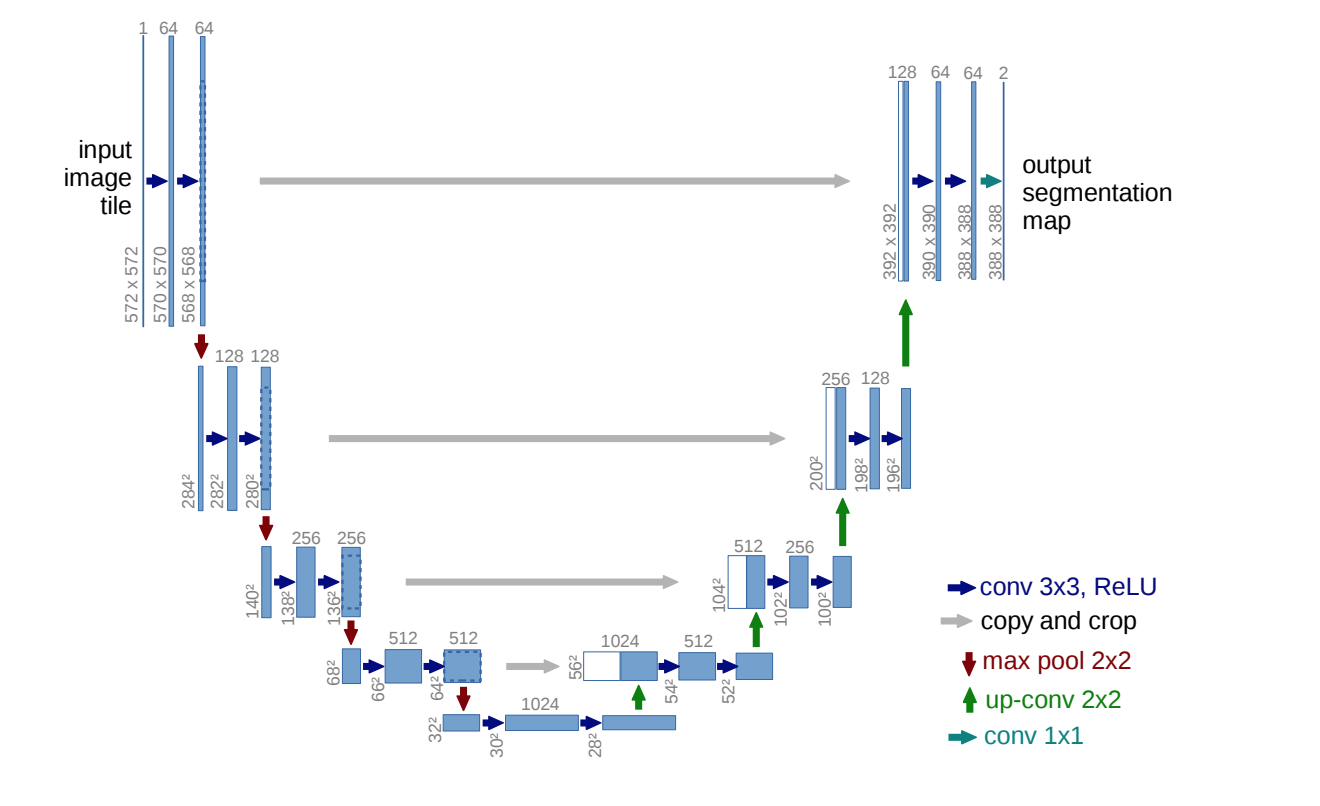

In addition to this, one of the salient features of the U-Net architecture is the skip connections (grey arrows), which enable the flow of information from the encoder side to the decoder side, enabling the model to make better predictions.

In [ ]:
# Download a built U-Net model which will be trained from scratch with the Tricuspid Doppler dataset
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
print(f"Model architecture: \n\n{model}")

Model architecture: 

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


**NOTE**: to edit a layer within the neural network we have to access it via the names within the round brackets e.g. `model.encoder1`, `model.decoder4.dec4conv1`, etc.

## Model set up and hyperparameters
In this section we will set up the loss function, optimizer and hyperparameters for the model.

In [ ]:
# Learning rate
LR = 0.1
# Epochs
EPOCHS = 20

In [ ]:
optimizer = torch.optim.Adam([ 
    dict(params = model.parameters(), lr = LR),
])

### **Image Segmentation evaluation**

We can compare each pixel one by one with the ground truth mask. But this is very problematic where there is a class imbalance. If we check whether the pixels are correctly classified and assigned value 0 for each of them or not. In the images the blood volume takes a smaller part of the image hence the matched pixels (background) will be at least 99% accurate. This leads to a class imbalance between the 1s (mask) and 0s (no mask). We can compare masks by using either **Jaccard's index** or **Dice Coefficient**.

#### **Jaccard's index**

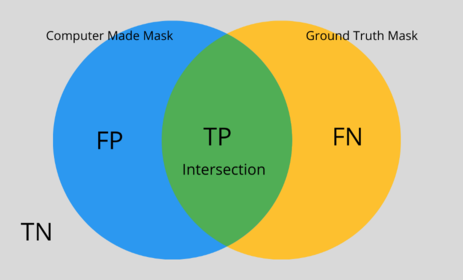

<br>

- **Green region**: We estimate 1 and the ground truth is 1. (True Positive, TP)

- **Blue region**: We estimate 1 but the ground truth is 0. (False Positive, FP)

- **Yellow region**: We estimate 0 but the ground truth is 1. (False Negative, FN)

- **Gray region**: We estimate 0 and the ground truth is 0. (True Negative, TN)

<br>

\begin{align}
  Jaccard Index = \frac{Intersection}{Union} = \frac{TP}{TP + FN + FP}
\end{align}

<br>

#### **Dice coefficient**

Dice coefficient is very similar to Jaccard’s Index. Dice coefficient double counts the intersection (TP).

<br>

\begin{align}
  Dice Coefficient = \frac{2 * Intersection}{Union + Intersection} = \frac{2 * TP}{(2 * TP) + FN + FP}
\end{align}

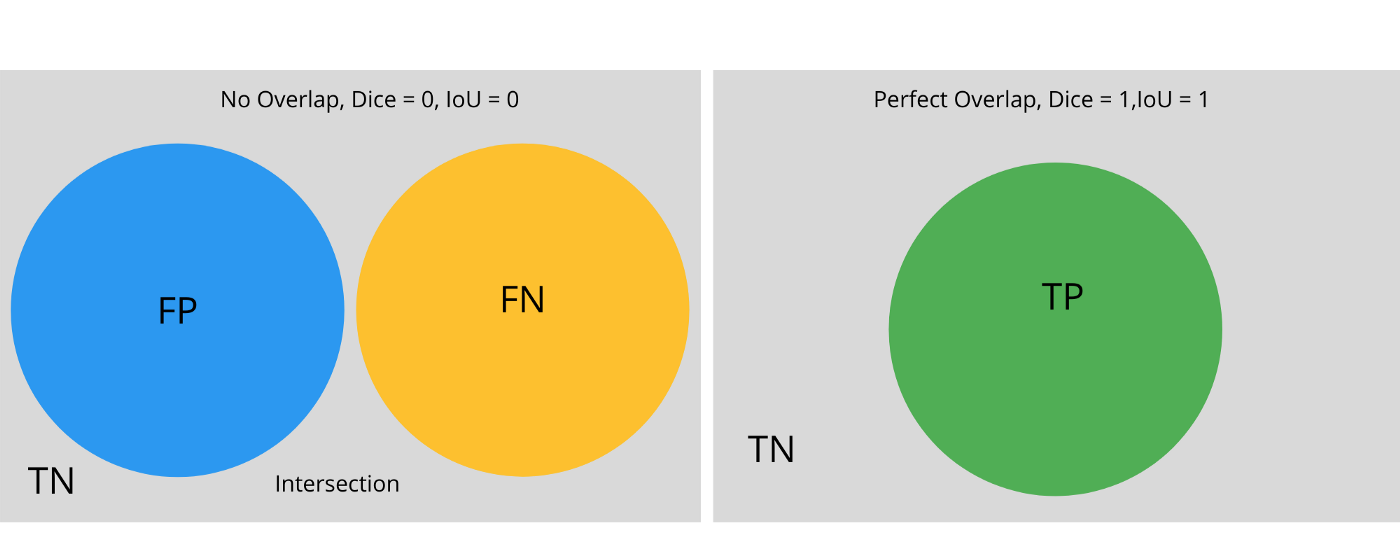



In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

## Training the model
So far we have prepared the data and created the U-Net model. In this section we will train the U-Net model.

In [ ]:
"""
  Either train the model by using smp or load the pretrained model and its history

  Parameters:
    - train - smp.utils.train.TrainEpoch()
    - test - smp.utils.train.ValidEpoch()
    - epochs - how many times should the model go over the dataset(s)
    - toTrain - True (train model) or False (load models - pretrained)
  Returns:
    - model - trained model
    - history - history of the model's performance
"""
def run(model, train, test, epochs, path, toTrain = True):

  # toTrain == True will train the model
  if toTrain:
    # Set model to training mode
    model.train()

    history = {
      "epochs": [],
      "train_logs": {
        "dice_loss": [],
        "iou_score": [] 
      },
      "test_logs": {
          "dice_loss": [],
          "iou_score": []
      }
    }

    # Store best IoU score
    score = 0.0

    for epoch in range(epochs):
      print(f"Epoch {epoch + 1} | {epochs}\n")

      trainLog = train.run(trainData)
      history["train_logs"]["dice_loss"].append(trainLog["dice_loss"])
      history["train_logs"]["iou_score"].append(trainLog["iou_score"])


      testLog = test.run(testData)
      history["test_logs"]["dice_loss"].append(testLog["dice_loss"])
      history["test_logs"]["iou_score"].append(testLog["iou_score"])

      history["epochs"].append(epoch + 1)
      
      # Check if current score is less than current iou score
      if score < testLog["iou_score"]:
        score = testLog["iou_score"]
        print("\n")
        saveModel(model, path)

      print("\n")
      print("-" * 80)
      print("\n")

    saveHistory(history, path)

  # toTrain == False will load the model and the history
  else:
    model = loadModel(path)
    history = loadHistory(path)
    
  return model, history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using {device.type} for processing.")

Currently using cuda for processing.


In [ ]:
train = smp.utils.train.TrainEpoch(model, loss = loss, metrics = metrics, optimizer = optimizer, device = device, verbose = True)

test = smp.utils.train.ValidEpoch(model, loss = loss, metrics = metrics, device = device, verbose = True)

In [ ]:
# Train the model
# model, history = run(model, train, test, EPOCHS, PATH, True)

## Model results

In this section we will see how well the model predicts and its training history.

In [ ]:
# Load the model and it's history
model, history = run(model, train, test, EPOCHS, PATH, False)

<Figure size 1080x504 with 0 Axes>

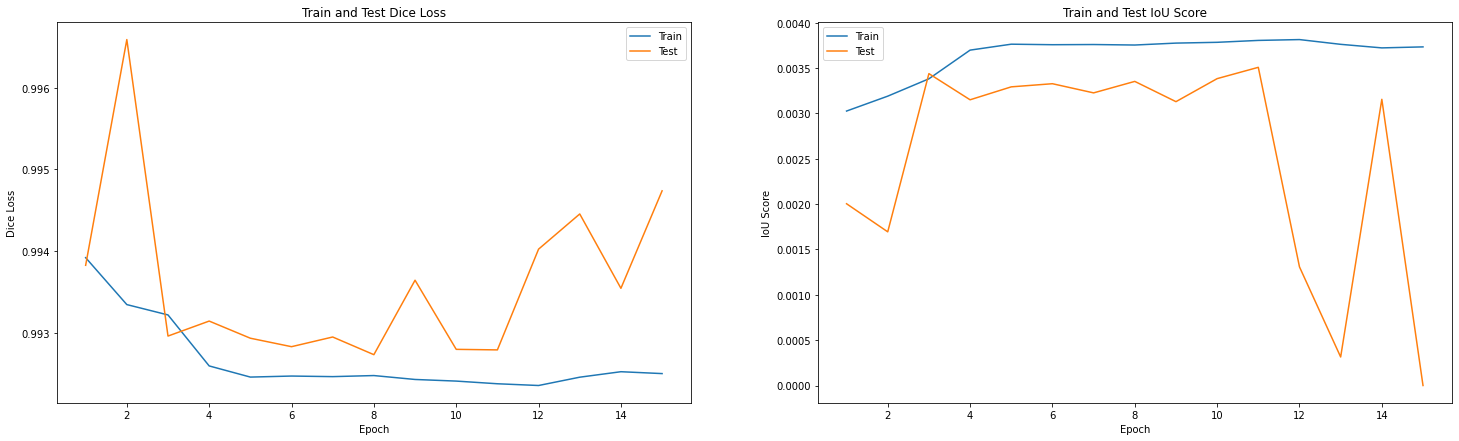

In [ ]:
# Display the model's train and test loss and IoU score
showHistory(history)

In [ ]:
"""
  Return 2D numpy array of input image, mask and prediction.

  NOTE: We return 2D numpy arrays so we can display them by 
  using the showTricuspid function
"""
def predict(model, device, image, mask):
  # Get the model's prediction and convert it to a 2D numpy array
  img = image.to(device)
  prediction = model(img)
  prediction = prediction.cpu().detach().numpy()
  prediction = np.reshape(prediction, (prediction.shape[2], prediction.shape[3]))
  
  # Convert the input image to a 2D numpy array
  img = reshapeBaseImage(img)

  # Get the mask of the image and convert it to a 2D numpy array
  mask = mask.cpu().detach().data.numpy()
  mask = np.reshape(mask, (mask.shape[2], mask.shape[3]))
  
  # Return 2D numpy arrays
  return img, mask, prediction

In [ ]:
"""
  Displays the prediction on top of the mask
"""
def stackImages(mask, prediction):
  mask = mask.copy()
  # Normalize mask
  mask = mask * 255

  # Make image 3d
  mask = np.expand_dims(mask, -1)

  # Make grey scale to RGB
  mask = np.tile(mask, [1, 1, 3])

  # Make image red
  mask[:, :, 1] = 0
  mask[:, :, 2] = 0

  prediction = prediction.copy()
  # Normalize prediction
  prediction = prediction * 255

  # Make image 3d
  prediction = np.expand_dims(prediction, -1)

  # Make grey scale to RGB
  prediction = np.tile(prediction, [1, 1, 3])
  # Make R (from RGB) filter values 0
  prediction[:, :, 0] = 0
  # Make B (from RGB) filter values 0
  prediction[:, :, 1] = 0

  plt.title("Prediction over Ground Truth")
  plt.imshow((mask + prediction))
  plt.axis("off")
  plt.show()

### Hausdorf distance

Hausdorff distance measures how far two subsets of a metric space are from each other. Informally, it is the greatest of all distances from a point in one set to the closest point in the other set. Two sets are “close” if for any one point on either set, the nearest point in the other set is “not too far”. 

In [ ]:
"""
  Calculate the distances between the surface 
  voxel of binary objects in result and their 
  nearest partner surface voxel of a binary 
  object in reference.
"""
def surfaceDistance(result, reference, voxelspacing=None, connectivity=1):

  result = np.array(result, dtype=np.bool)
  result = np.atleast_1d(result)
  reference = np.array(reference, dtype=np.bool)
  reference = np.atleast_1d(reference)

  if voxelspacing is not None:
      voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
      voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
      if not voxelspacing.flags.contiguous:
          voxelspacing = voxelspacing.copy()
          
  # binary structure
  footprint = generate_binary_structure(result.ndim, connectivity)

  # test for emptiness
  if 0 == np.count_nonzero(result): 
      raise RuntimeError('The first supplied array does not contain any binary object.')
  if 0 == np.count_nonzero(reference): 
      raise RuntimeError('The second supplied array does not contain any binary object.')    
          
  # extract only 1-pixel border line of objects
  result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
  reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)

  # compute average surface distance        
  dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
  sds = dt[result_border]

  return sds

def hausdorffDistance(reference, result, voxelspacing=None, connectivity=1):
  hd1 = surfaceDistance(result, reference, voxelspacing, connectivity).max()
  hd2 = surfaceDistance(reference, result, voxelspacing, connectivity).max()
  hd = max(hd1, hd2)
  return hd

### Dice coefficient

In [ ]:
# Computes the Dice coefficient
def diceCoefficient(reference, result):
  result = np.array(result, dtype=np.bool)
  result = np.atleast_1d(result)
  result = np.reshape(result, [-1])

  reference = np.array(reference, dtype=np.bool)
  reference = np.atleast_1d(reference)
  reference = np.reshape(reference, [-1])

  intersection = np.count_nonzero(result & reference)

  size_i1 = np.count_nonzero(result)
  size_i2 = np.count_nonzero(reference)

  try:
    dc = 2. * intersection / float(size_i1 + size_i2)
  except ZeroDivisionError:
    dc = 0.0

  return dc

### Evaluate

Hausdorff Distance:	556.8707210834486

Dice Coefficient:	0.05660188524681313



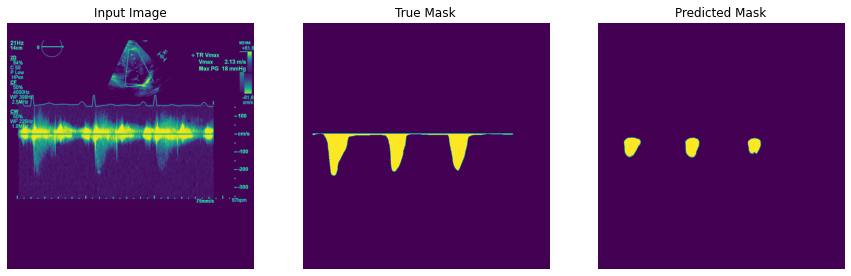

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


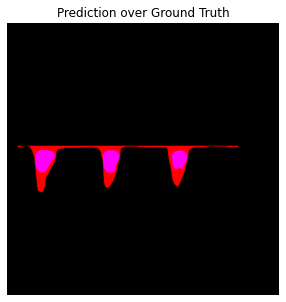

Hausdorff Distance:	470.0

Dice Coefficient:	0.13209088228928315



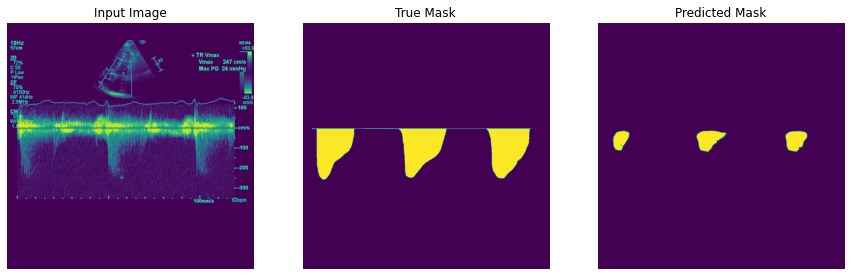

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


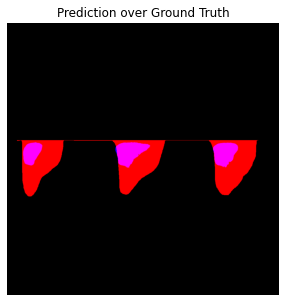

Hausdorff Distance:	505.0

Dice Coefficient:	0.08256531788525118



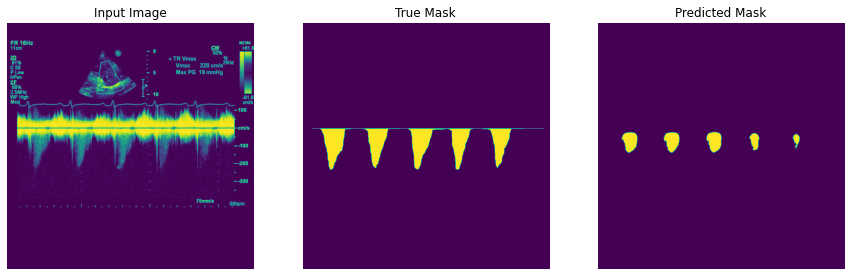

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


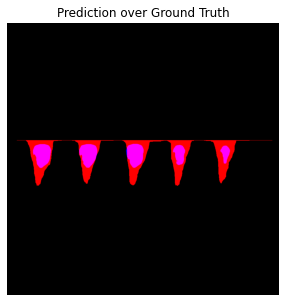

Hausdorff Distance:	505.88733923671185

Dice Coefficient:	0.08829486803171542



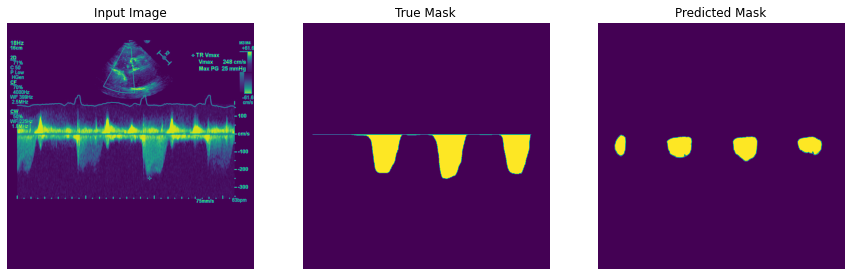

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


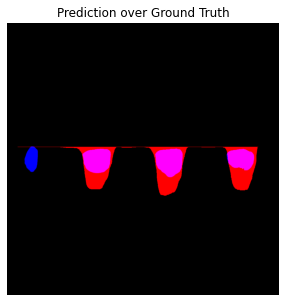

Hausdorff Distance:	532.8461316365166

Dice Coefficient:	0.11640441647348562



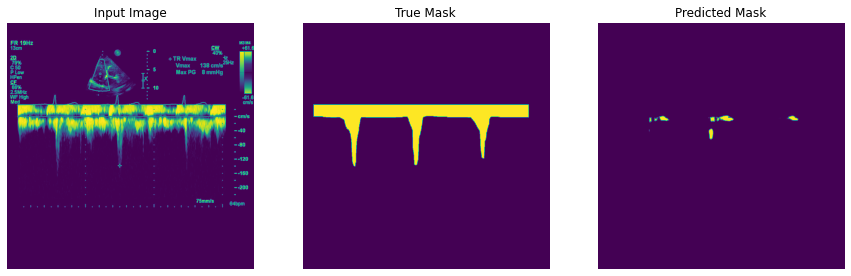

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


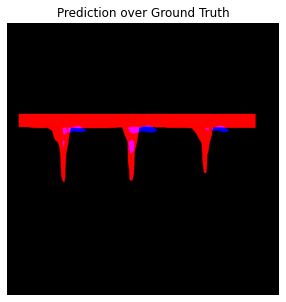

Hausdorff Distance:	460.0

Dice Coefficient:	0.16732819837911622



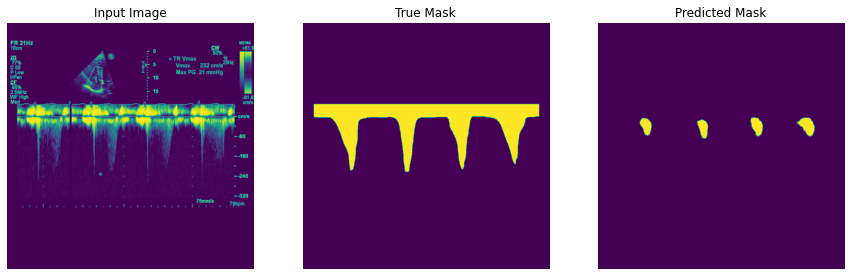

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


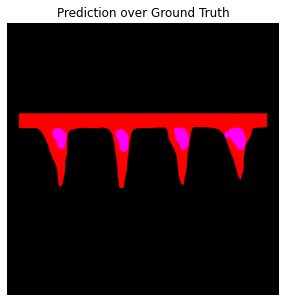

Hausdorff Distance:	481.6741637248151

Dice Coefficient:	0.07933590319162478



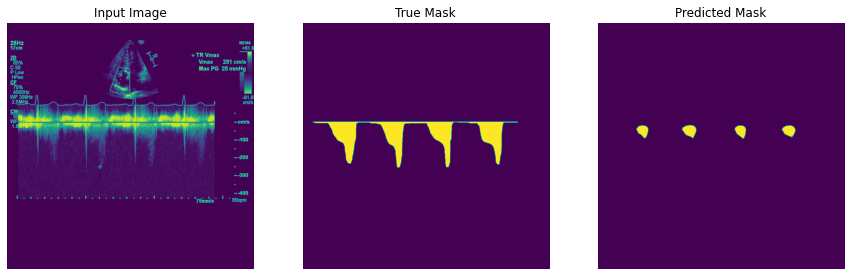

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


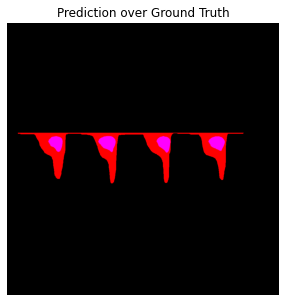

Hausdorff Distance:	466.0

Dice Coefficient:	0.11994373687216096



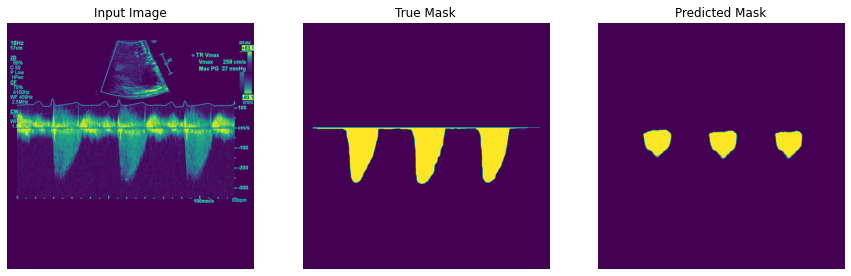

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


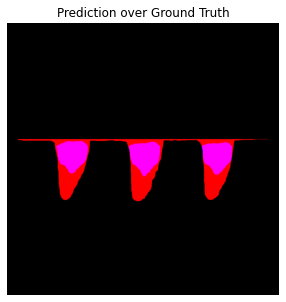

Hausdorff Distance:	525.8631000555182

Dice Coefficient:	0.09080621858638863



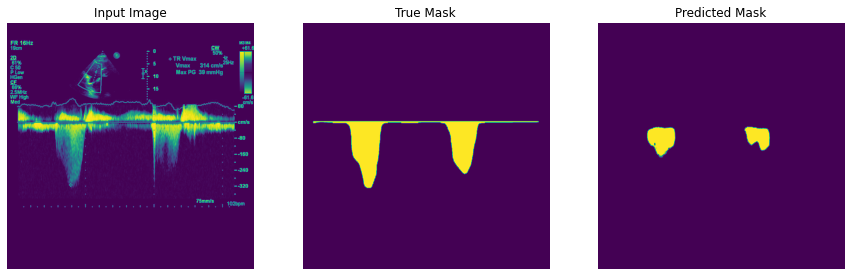

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


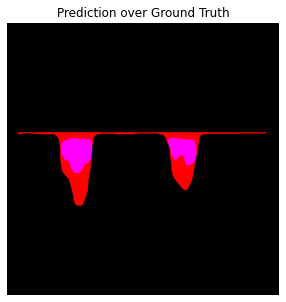

Hausdorff Distance:	495.0

Dice Coefficient:	0.05607407331879279



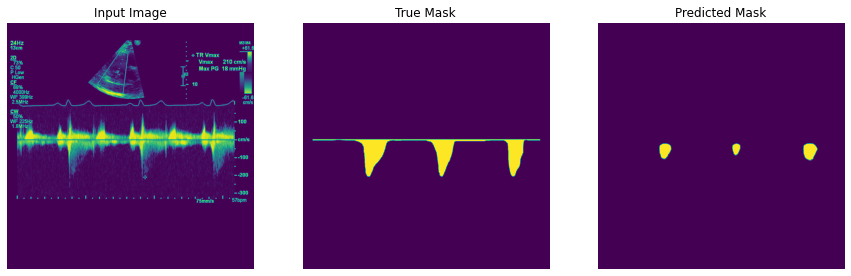

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


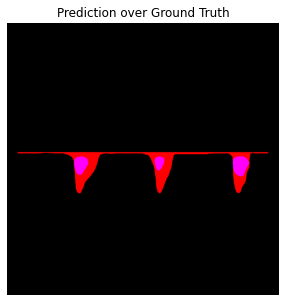

Hausdorff Distance:	582.5160941982633

Dice Coefficient:	0.06721939386789845



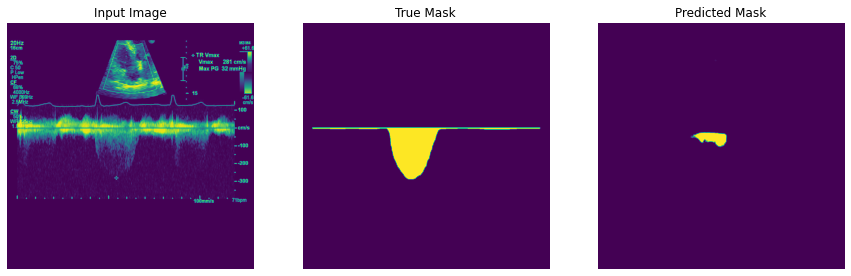

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


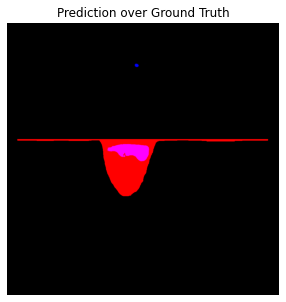

Hausdorff Distance:	488.41990131443254

Dice Coefficient:	0.11203626932276799



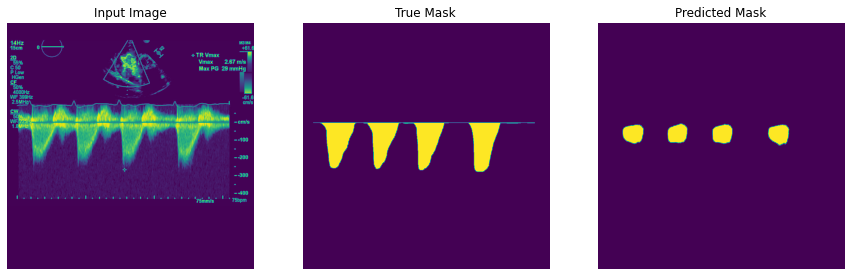

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


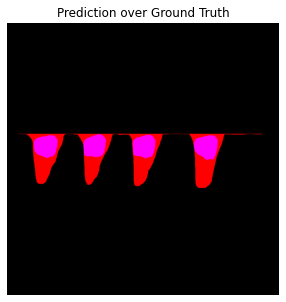

Hausdorff Distance:	517.5712511336

Dice Coefficient:	0.08018513839607752



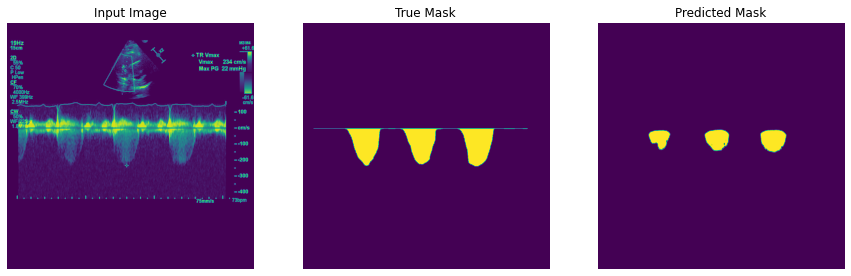

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


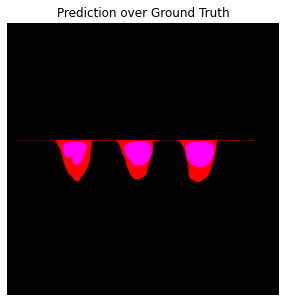

Hausdorff Distance:	496.3909749381026

Dice Coefficient:	0.061412801328164145



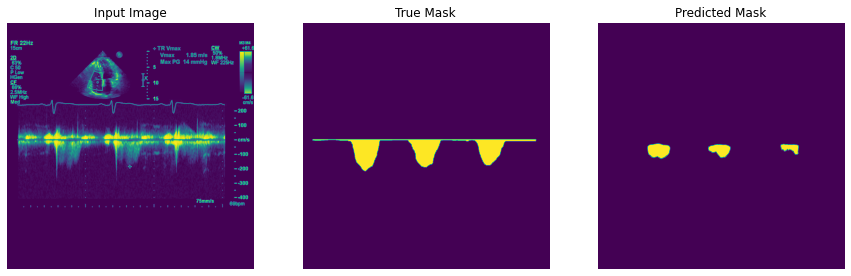

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


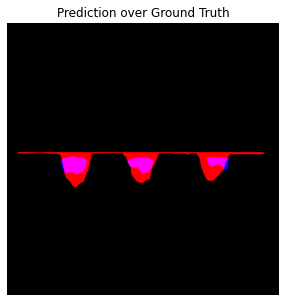

Hausdorff Distance:	474.2931582892589

Dice Coefficient:	0.21896104249045426



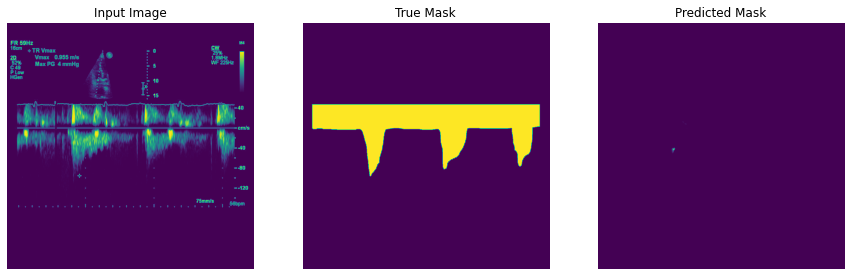

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


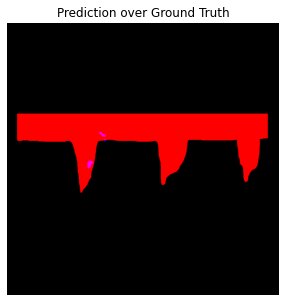

Hausdorff Distance:	493.0

Dice Coefficient:	0.06112603708833117



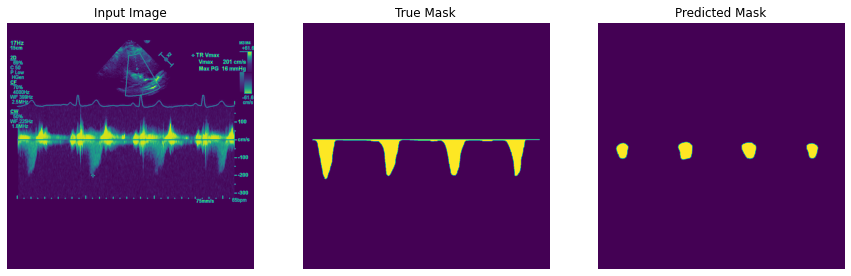

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


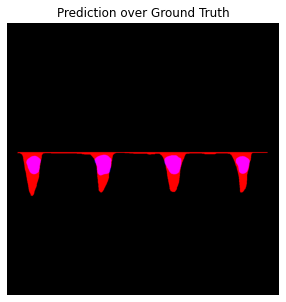

Hausdorff Distance:	503.0

Dice Coefficient:	0.07022332072367361



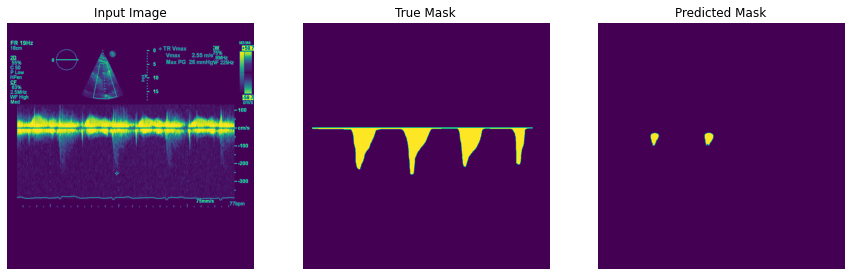

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


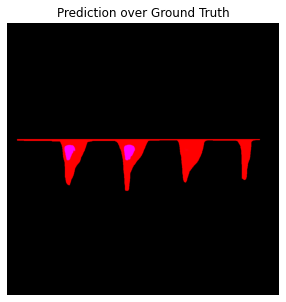

Hausdorff Distance:	505.4394127885161

Dice Coefficient:	0.08893420924334752



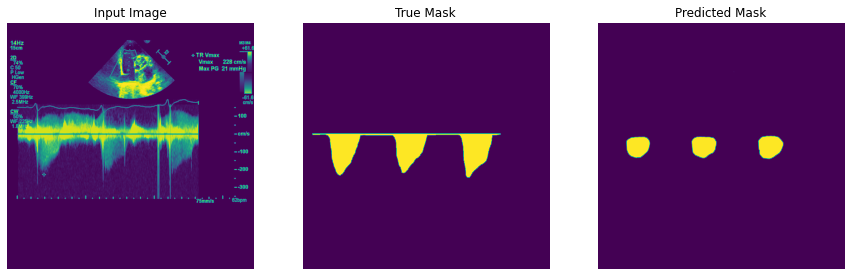

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


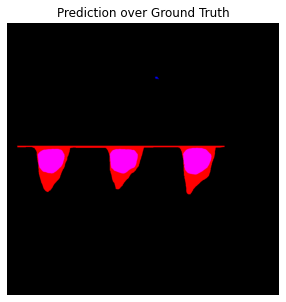

Hausdorff Distance:	515.6006206357786

Dice Coefficient:	0.219323986523204



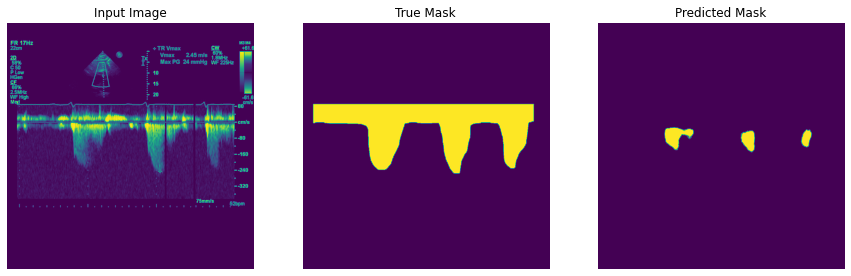

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


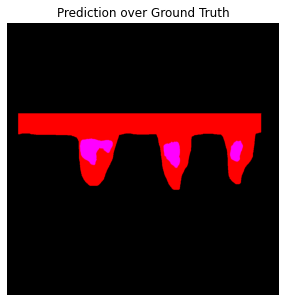

In [ ]:
# Put model in evaluation mode
model.eval()

# NOTE: testData's batch size is 1
for img, mask in testData:
  # Get 2d numpy arrays of the input image, true mask and predicted mask
  img, mask, prediction = predict(model, device, img, mask)

  print(f"Hausdorff Distance:\t{hausdorffDistance(mask, prediction)}\n")
  print(f"Dice Coefficient:\t{diceCoefficient(mask, prediction)}\n")

  showTricuspid([img, mask, prediction])
  stackImages(mask, prediction)

### Beat Area Calculation

In the final part of this notebook, we will calculate the area per beat within the masks (ground truth). In this notebook's version the u-net predictions are not accurate enough and we will present the calculations of the ground truth masks.

We will calculate the area of the beat in the following steps:

1. Calculate the vertical sum for each column. This will return a 1D array with a shape of `(1024,)`.

2. Get the most frequent number that is inside vertical sum from the previous step.

3. Find the centres by using `find_peaks` in `scipy.signal`. This will return the coordinates of the beat's centre in the horizontal axis.

4. Get the edges on the X axis so we can find the curve of the beat by using sober edge detection. Then we remove the noise from image - if a pixel value greater than 10 then the returned value is 255, otherwise we will return 0.

5. Use morphology to clean the image gaps in the edge deteciton.

6. Group connected pixels together to get a contour. We sort the pixels by X axis, so they are displayed in the order they are shown - from left to right. Afterwards the smallest groups from the found contours, values smaller than area than `300 + _mode`, are removed.

7. For every heart beat center:
  - Find the starting point of the beat - lowest point in every axis of beat
  - Find the end point of the beat - largest point in every axis.
  - Represent the beat with a different contour if the beat contours are not linked together and if they have a gap in between. If the largest value in the contour is still smaller than our current beat centre, we will go to the next contour and find the end of the beat until we can find the end of the current beat.

In [ ]:
def beatArea(mask):
  # Calculate the sum for the vertical axis
  verticleSum = mask.sum(axis=0) 
  # Get the most frequent value in verticleSum
  _mode = mode(verticleSum)
  
  # Calculate the beat centers from the verticleSum 
  beatCenters = find_peaks(verticleSum, height=50+_mode, distance=50)[0] 
  # Filter beat centers
  beatCenters = list(filter(lambda center: verticleSum[center-5] >= _mode+20 and verticleSum[center+5] >= _mode+20, beatCenters))

  # Calculate the delivery of the x axis
  sobelx = np.abs(cv2.Sobel(mask,cv2.CV_64F,1,0,ksize=5))
  # Threshold the result
  sobelx = cv2.threshold(sobelx, 10, 255, cv2.THRESH_BINARY)[1]

  # Use morphology to remove noise
  closing = np.uint8(cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), iterations=3))
  cnts = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0] # find contour
  
  # Remove contours with an area smaller than 300 + _mode
  cnts = list(filter(lambda x: cv2.contourArea(x) > 300+_mode, cnts)) 
  # Sort the contours by X axis
  cnts = sorted(cnts, key=lambda x: x[0][0][0]) 

  currentCenter = 0

  boundaries = []

  # For each beat center - find the beginning and end
  for center in beatCenters:
    x1 = np.min(cnts[currentCenter].reshape(-1,2)[:, 0])
    while np.max(cnts[currentCenter].reshape(-1,2)[:, 0]) - center < 5:
      currentCenter += 1
    
    x2 = np.max(cnts[currentCenter].reshape(-1,2)[:, 0])
    boundaries += [[x1,x2]]
    currentCenter += 1

  # Visualize beats in different colours
  h, w = mask.shape
  vizRet = np.zeros((h,w, 3), dtype=np.uint8)

  areas = []
  for x1,x2 in boundaries:
    pos = np.vstack(np.where(mask[:, x1:x2] == 1))
    pos[1] += x1 
    color = np.random.randint(0,255,3) 
    vizRet[pos[0], pos[1]] = color
    # Calculate the area of the beat
    areas += [verticleSum[x1:x2+1].sum()]

  return areas, vizRet

The area of beat 1 is:	15525

The area of beat 2 is:	14121

The area of beat 3 is:	15145

The area of beat 4 is:	16846



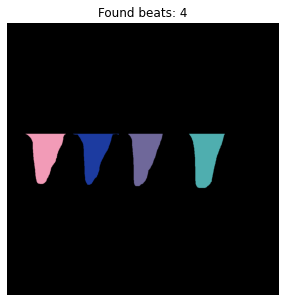

In [ ]:
showRandombeat(PATH)

**NOTE**: In order to use `beatArea` with predicted results, we have to be saved as images instead of used as tensors on numpy arrays.

## Model results

To make more accurate predictions more experiments will have to be done when designing the model. The proposed model underfits the data. The data set is also considerably small for the model to learn. The model will have to be either more data, a different model might be required or both.